<a href="https://colab.research.google.com/github/ian734/Fraudulent-Medicare-Claims-Detection---Applications-of-Deep-Learning-and-Topic-Model-/blob/main/Code_for_A2byENGIN__GPT9_1(with_BERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **匯入套件**

In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import matplotlib.pyplot as plt
import sklearn.preprocessing
import tensorflow.compat.v1 as tf

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import recall_score, precision_score, accuracy_score, mean_squared_error, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

-------------------------
**LSTM**
*  Accuracy Score: 83.67%
*  Precision Score: 99.35%
*  Recall Score: 83.67%
*  F1 score: 90.62%
--------------------------


-------------------------
**RNN**
*   Accuracy Score: 74.22%
*   Precision Score: 99.35%
*   Recall Score: 74.22%
*   F1 score: 84.71%
--------------------------

-------------------------
**GRU**
* Accuracy Score: 77.60%
* Precision Score: 99.36%
* Recall Score: 77.60%
* F1 score: 86.89%
--------------------------

In [ ]:
# read data file
dataset = pd.read_csv("/content/gdrive/MyDrive/paper/df_tag.csv")
dataset.columns = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','y']
dataset.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,11.0,11,25.410000,1.801382e-02,1.706322e-02,0.015318,2.434581e-02,3.466277e-03,24.992727,0
1,11.0,11,20.250000,6.110000e-306,6.520000e-306,1.000000,1.080000e-305,1.100000e-306,15.967273,0
2,11.0,11,27.540000,1.686391e-02,1.598200e-02,0.014344,2.280891e-02,3.246517e-03,26.990000,0
3,11.0,11,4.610000,6.058555e-03,8.006379e-03,0.007319,1.300794e-02,1.289546e-03,4.610000,0
4,11.0,11,160.817273,6.398337e-02,4.318306e-02,0.063822,8.986368e-02,4.442321e-01,118.473636,0


# **1.LSTM**

In [ ]:
# -*- coding: utf-8 -*---
##  提供的資料格式   第一列是變數名稱
##  x1,x2,x3,x4…,xn,y


# parameters
x_no= 9     ## x的變數個數
y_no= 1     ## y的變數個數

window=1
ahead=0
seq_len = window + ahead

In [ ]:
data_length= len(dataset)

df_stock = dataset.copy()
df_stock = df_stock.dropna()  ## 去掉空的資料列!!

df_stock_X = df_stock.iloc[:,:-1]
df_stock_Y = df_stock.iloc[:,-1]

In [ ]:
# normalize the dataset
from sklearn import preprocessing as skpp
from pandas import DataFrame

scaler = skpp.MinMaxScaler(feature_range=(0, 1))
df_stock_Xnorm = DataFrame(scaler.fit_transform(df_stock_X))

In [ ]:
## 轉為 DataFrame
df_stock_Y = DataFrame(df_stock_Y)

##  將X and Y合併!
df_stock_Xnorm['tmp'] = np.arange(0,len(df_stock_Xnorm))
df_stock_Y['tmp'] = np.arange(0,len(df_stock_Y))

df_stock_new= pd.merge(df_stock_Xnorm, df_stock_Y, on=['tmp'])
df_stock_new = df_stock_new.drop('tmp', axis=1)

df_stock_norm= df_stock_new

In [ ]:
############################
# data windows + Splitting the dataset into Train, Valid & test data
valid_set_size_percentage = 10
test_set_size_percentage = 10

def load_data(stock, seq_len):
    data_raw = stock
    data = []
    for index in range(len(data_raw) - seq_len+1):
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/1000*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:window,: -y_no]
    y_train = data[:train_set_size,-1, -y_no:]
    x_valid = data[train_set_size:train_set_size+valid_set_size, :window,: -y_no]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1, -y_no:]
    x_test = data[train_set_size+valid_set_size:, :window,: -y_no]
    y_test = data[train_set_size+valid_set_size:,-1, -y_no:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


x_train, y_train, x_valid, y_valid, x_test, y_test= [],[],[],[],[],[]

i=0
df_stock_norm_temp = df_stock_norm.iloc[np.arange(data_length*i, data_length*i + data_length),:]
x_traint, y_traint, x_validt, y_validt, x_testt, y_testt = load_data(df_stock_norm_temp, seq_len)
x_train.append(x_traint)
y_train.append(y_traint)
x_valid.append(x_validt)
y_valid.append(y_validt)
x_test.append(x_testt)
y_test.append(y_testt)

In [ ]:
##  4D to  3D
x_train=np.reshape(np.array(x_train), (-1, window, x_no))
y_train=np.reshape(np.array(y_train), (-1, y_no))

x_valid=np.reshape(np.array(x_valid), (-1, window, x_no))
y_valid=np.reshape(np.array(y_valid), (-1, y_no))

x_test=np.reshape(np.array(x_test), (-1, window, x_no))
y_test=np.reshape(np.array(y_test), (-1, y_no))

Class=0, n=135707 (98.689%)
Class=1, n=1803 (1.311%)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


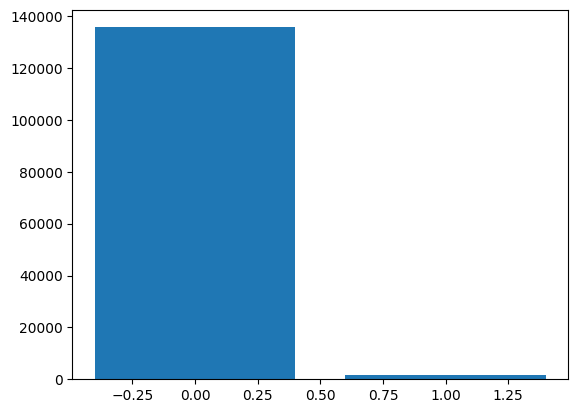

In [ ]:
#########################################
##  看y 的 level 分布情形!
X=x_train
y=y_train

from sklearn.preprocessing import LabelEncoder
from collections import Counter

y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

Class=0, n=135707 (50.000%)
Class=1, n=135707 (50.000%)


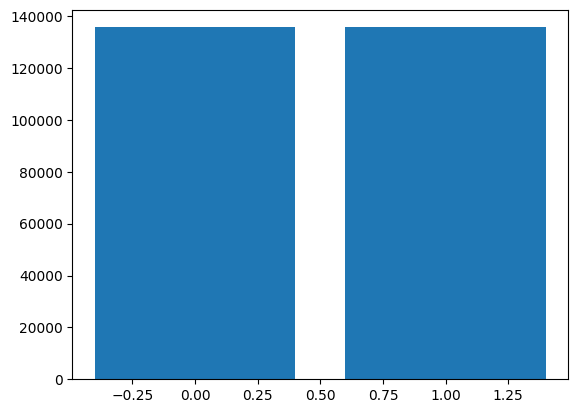

In [ ]:
##########################
## SMOTE

from imblearn.over_sampling import SMOTE

X=np.reshape(np.array(X), (len(x_train), -1))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
###########################
##  reshape x 資料
X=np.reshape(np.array(X), (-1, window ,x_no))

y_level=len(np.unique(y))   ## y 有多少levels

##  one-hot encoding
from keras.utils import np_utils
y_oneshot = np_utils.to_categorical(y)

y_valid= np_utils.to_categorical(y_valid)
y_test= np_utils.to_categorical(y_test)

In [ ]:
############################################

x_train=X
y_train= y_oneshot

############################################

In [ ]:
"""Building the LSTM Model"""

# parameters & Placeholders
n_steps = window
n_inputs = x_no
n_neurons = 256
n_outputs = y_level
n_layers = 2
learning_rate = 0.0005
batch_size = 150
n_epochs = 20
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
tf.disable_eager_execution()

In [ ]:
##用 tf.placeholder 創造出未來存放 x 與 y 值的地方
X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])
# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)  ## 隨機排列

In [ ]:
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [ ]:
# LSTM

layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
        for layer in range(n_layers)]
multi_layer_cell =tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)

outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

# Cost function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits= outputs,labels=y) )

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Fitting the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

##########  confusion accuracy
from numpy import argmax
argmax(y_test, axis=1, out=None)
argmax(y_test_pred, axis=1, out=None)

from sklearn.metrics import confusion_matrix
target=argmax(y_test, axis=1, out=None)
prediction=argmax(y_test_pred, axis=1, out=None)
cm = confusion_matrix(target, prediction)

from sklearn.metrics import accuracy_score
score = accuracy_score(target, prediction)
print("Accuracy {}%".format(score))

from sklearn.metrics import mean_squared_error
rmse= mean_squared_error(target, prediction)
print("RMSE {}%".format(rmse))



<ipython-input-17-9d707457d4fa>:3: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
<ipython-input-17-9d707457d4fa>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)


ValueError: ignored

In [ ]:
##### confusion matrix-- visualization
import seaborn as sn
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')
plt.title('LSTM confusion_matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
# undersample
# 只抓前面5000筆做0

# 計算指標
print(f"Accuracy Score: {accuracy_score(target, prediction)*100:.2f}%")
print(f"Precision Score: {precision_score(target, prediction,average='weighted')*100:.2f}%")
print(f"Recall Score: {recall_score(target, prediction,average='weighted')*100:.2f}%")
print(f"F1 score: {f1_score(target, prediction,average='weighted')*100:.2f}%")

# **2.RNN**

In [ ]:
# -*- coding: utf-8 -*-
##  提供的資料格式   第一列是變數名稱
##  x1,x2,x3,x4…,xn,y

# parameters
x_no= 9     ## x的變數個數
y_no= 1     ## y的變數個數

window=1
ahead=0
seq_len = window + ahead



# read data file
# read data file
dataset = pd.read_csv("/content/gdrive/MyDrive/paper/df_tag.csv")
dataset.columns = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','y']
dataset.head()

data_length= len(dataset)

df_stock = dataset.copy()
df_stock = df_stock.dropna()  ## 去掉空的資料列!!

df_stock_X = df_stock.iloc[:,:-1]
df_stock_Y = df_stock.iloc[:,-1]

# normalize the dataset
from sklearn import preprocessing as skpp
from pandas import DataFrame

scaler = skpp.MinMaxScaler(feature_range=(0, 1))
df_stock_Xnorm = DataFrame(scaler.fit_transform(df_stock_X))

## 轉為 DataFrame
df_stock_Y = DataFrame(df_stock_Y)

##  將X and Y合併!
df_stock_Xnorm['tmp'] = np.arange(0,len(df_stock_Xnorm))
df_stock_Y['tmp'] = np.arange(0,len(df_stock_Y))

df_stock_new= pd.merge(df_stock_Xnorm, df_stock_Y, on=['tmp'])
df_stock_new = df_stock_new.drop('tmp', axis=1)

df_stock_norm= df_stock_new

In [ ]:
############################
# data windows + Splitting the dataset into Train, Valid & test data
valid_set_size_percentage = 1
test_set_size_percentage = 10

def load_data(stock, seq_len):
    data_raw = stock
    data = []
    for index in range(len(data_raw) - seq_len+1):
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:window,: -y_no]
    y_train = data[:train_set_size,-1, -y_no:]
    x_valid = data[train_set_size:train_set_size+valid_set_size, :window,: -y_no]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1, -y_no:]
    x_test = data[train_set_size+valid_set_size:, :window,: -y_no]
    y_test = data[train_set_size+valid_set_size:,-1, -y_no:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


x_train, y_train, x_valid, y_valid, x_test, y_test= [],[],[],[],[],[]

i=0
df_stock_norm_temp = df_stock_norm.iloc[np.arange(data_length*i, data_length*i + data_length),:]
x_traint, y_traint, x_validt, y_validt, x_testt, y_testt = load_data(df_stock_norm_temp, seq_len)
x_train.append(x_traint)
y_train.append(y_traint)
x_valid.append(x_validt)
y_valid.append(y_validt)
x_test.append(x_testt)
y_test.append(y_testt)


##  4D to  3D
x_train=np.reshape(np.array(x_train), (-1, window, x_no))
y_train=np.reshape(np.array(y_train), (-1, y_no))

x_valid=np.reshape(np.array(x_valid), (-1, window, x_no))
y_valid=np.reshape(np.array(y_valid), (-1, y_no))

x_test=np.reshape(np.array(x_test), (-1, window, x_no))
y_test=np.reshape(np.array(y_test), (-1, y_no))

Class=0, n=103848 (98.396%)
Class=1, n=1693 (1.604%)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


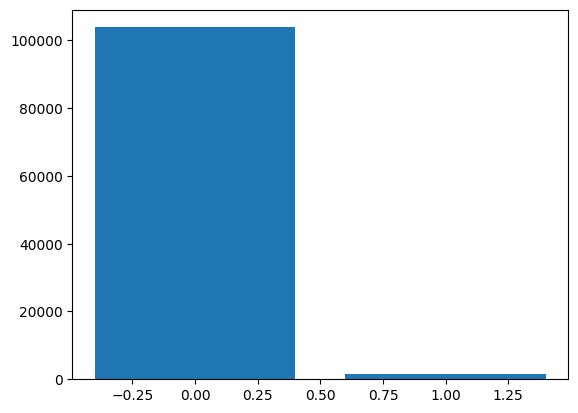

In [ ]:
#########################################
##  看y 的 level 分布情形!
X=x_train
y=y_train

from sklearn.preprocessing import LabelEncoder
from collections import Counter

y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

Class=0, n=103848 (50.000%)
Class=1, n=103848 (50.000%)


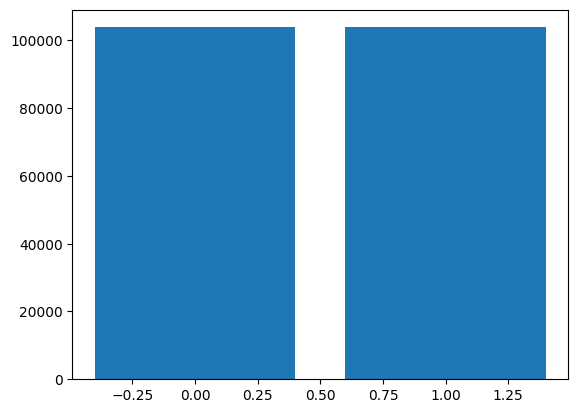

In [ ]:
##########################
## SMOTE

from imblearn.over_sampling import SMOTE

X=np.reshape(np.array(X), (len(x_train), -1))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
###########################
##  reshape x 資料
X=np.reshape(np.array(X), (-1, window ,x_no))

y_level=len(np.unique(y))   ## y 有多少levels

##  one-hot encoding
from keras.utils import np_utils
y_oneshot = np_utils.to_categorical(y)

y_valid= np_utils.to_categorical(y_valid)
y_test= np_utils.to_categorical(y_test)

In [ ]:
############################################

x_train=X
y_train= y_oneshot

############################################

"""Building the LSTM Model"""

# parameters & Placeholders
n_steps = window
n_inputs = x_no
n_neurons = 256
n_outputs = y_level
n_layers = 2
learning_rate = 0.0005
batch_size = 150
n_epochs = 20
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
tf.disable_eager_execution()

##用 tf.placeholder 創造出未來存放 x 與 y 值的地方
X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)  ## 隨機排列

In [ ]:
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [ ]:
# RNN

layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
        for layer in range(n_layers)]
multi_layer_cell =tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)

outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

# Cost function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits= outputs,labels=y) )

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Fitting the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

##########  confusion accuracy
from numpy import argmax
argmax(y_test, axis=1, out=None)
argmax(y_test_pred, axis=1, out=None)

from sklearn.metrics import confusion_matrix
target=argmax(y_test, axis=1, out=None)
prediction=argmax(y_test_pred, axis=1, out=None)
cm = confusion_matrix(target, prediction)

from sklearn.metrics import accuracy_score
score = accuracy_score(target, prediction)
print("Accuracy {}%".format(score))

from sklearn.metrics import mean_squared_error
rmse= mean_squared_error(target, prediction)
print("RMSE {}%".format(rmse))


<ipython-input-27-dcc97c58eea6>:3: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
<ipython-input-27-dcc97c58eea6>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)


0.00 epochs: MSE train/valid = 0.690421/0.686173
5.00 epochs: MSE train/valid = 0.339641/0.614667
10.00 epochs: MSE train/valid = 0.294124/0.733761
15.00 epochs: MSE train/valid = 0.280501/0.480513
Accuracy 0.7422419804741981%
RMSE 0.25775801952580196%


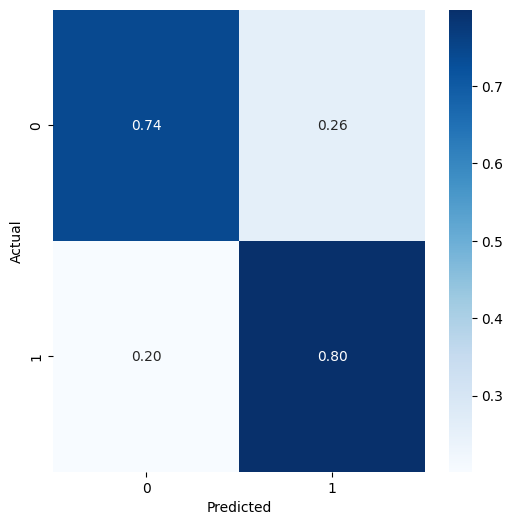

In [ ]:

##### confusion matrix-- visualization
import seaborn as sn
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
# 計算指標
print(f"Accuracy Score: {accuracy_score(target, prediction)*100:.2f}%")
print(f"Precision Score: {precision_score(target, prediction,average='weighted')*100:.2f}%")
print(f"Recall Score: {recall_score(target, prediction,average='weighted')*100:.2f}%")
print(f"F1 score: {f1_score(target, prediction,average='weighted')*100:.2f}%")

Accuracy Score: 74.22%
Precision Score: 99.35%
Recall Score: 74.22%
F1 score: 84.71%


In [ ]:
Accuracy Score: 74.22%
Precision Score: 99.35%
Recall Score: 74.22%
F1 score: 84.71%

# **3.GRU**

In [ ]:
# -*- coding: utf-8 -*-
##  提供的資料格式   第一列是變數名稱
##  x1,x2,x3,x4…,xn,y

# parameters
x_no= 9     ## x的變數個數
y_no= 1     ## y的變數個數

window=1
ahead=0
seq_len = window + ahead



# read data file
# read data file
dataset = pd.read_csv("/content/gdrive/MyDrive/paper/df_tag.csv")
dataset.columns = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','y']
dataset.head()

data_length= len(dataset)

df_stock = dataset.copy()
df_stock = df_stock.dropna()  ## 去掉空的資料列!!

df_stock_X = df_stock.iloc[:,:-1]
df_stock_Y = df_stock.iloc[:,-1]

# normalize the dataset
from sklearn import preprocessing as skpp
from pandas import DataFrame

scaler = skpp.MinMaxScaler(feature_range=(0, 1))
df_stock_Xnorm = DataFrame(scaler.fit_transform(df_stock_X))

## 轉為 DataFrame
df_stock_Y = DataFrame(df_stock_Y)

##  將X and Y合併!
df_stock_Xnorm['tmp'] = np.arange(0,len(df_stock_Xnorm))
df_stock_Y['tmp'] = np.arange(0,len(df_stock_Y))

df_stock_new= pd.merge(df_stock_Xnorm, df_stock_Y, on=['tmp'])
df_stock_new = df_stock_new.drop('tmp', axis=1)

df_stock_norm= df_stock_new

In [ ]:
############################
# data windows + Splitting the dataset into Train, Valid & test data
valid_set_size_percentage = 1
test_set_size_percentage = 10

def load_data(stock, seq_len):
    data_raw = stock
    data = []
    for index in range(len(data_raw) - seq_len+1):
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:window,: -y_no]
    y_train = data[:train_set_size,-1, -y_no:]
    x_valid = data[train_set_size:train_set_size+valid_set_size, :window,: -y_no]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1, -y_no:]
    x_test = data[train_set_size+valid_set_size:, :window,: -y_no]
    y_test = data[train_set_size+valid_set_size:,-1, -y_no:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


x_train, y_train, x_valid, y_valid, x_test, y_test= [],[],[],[],[],[]

i=0
df_stock_norm_temp = df_stock_norm.iloc[np.arange(data_length*i, data_length*i + data_length),:]
x_traint, y_traint, x_validt, y_validt, x_testt, y_testt = load_data(df_stock_norm_temp, seq_len)
x_train.append(x_traint)
y_train.append(y_traint)
x_valid.append(x_validt)
y_valid.append(y_validt)
x_test.append(x_testt)
y_test.append(y_testt)


##  4D to  3D
x_train=np.reshape(np.array(x_train), (-1, window, x_no))
y_train=np.reshape(np.array(y_train), (-1, y_no))

x_valid=np.reshape(np.array(x_valid), (-1, window, x_no))
y_valid=np.reshape(np.array(y_valid), (-1, y_no))

x_test=np.reshape(np.array(x_test), (-1, window, x_no))
y_test=np.reshape(np.array(y_test), (-1, y_no))

Class=0, n=103848 (98.396%)
Class=1, n=1693 (1.604%)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


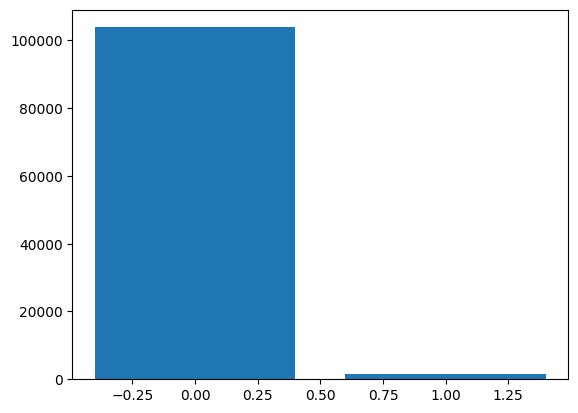

In [ ]:
#########################################
##  看y 的 level 分布情形!
X=x_train
y=y_train

from sklearn.preprocessing import LabelEncoder
from collections import Counter

y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

Class=0, n=103848 (50.000%)
Class=1, n=103848 (50.000%)


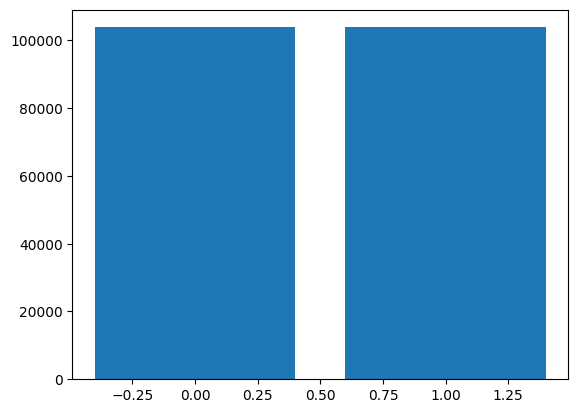

In [ ]:
##########################
## SMOTE

from imblearn.over_sampling import SMOTE

X=np.reshape(np.array(X), (len(x_train), -1))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
###########################
##  reshape x 資料
X=np.reshape(np.array(X), (-1, window ,x_no))

y_level=len(np.unique(y))   ## y 有多少levels

##  one-hot encoding
from keras.utils import np_utils
y_oneshot = np_utils.to_categorical(y)

y_valid= np_utils.to_categorical(y_valid)
y_test= np_utils.to_categorical(y_test)

In [ ]:
############################################

x_train=X
y_train= y_oneshot

############################################

"""Building the LSTM Model"""

# parameters & Placeholders
n_steps = window
n_inputs = x_no
n_neurons = 256
n_outputs = y_level
n_layers = 2
learning_rate = 0.0005
batch_size = 150
n_epochs = 20
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
tf.disable_eager_execution()

##用 tf.placeholder 創造出未來存放 x 與 y 值的地方
X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)  ## 隨機排列

In [ ]:
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [ ]:
# RNN

# layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#         for layer in range(n_layers)]
# multi_layer_cell =tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
# rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
# stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
# stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)

layers = [tf.compat.v1.nn.rnn_cell.GRUCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)


outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

# Cost function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits= outputs,labels=y) )

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Fitting the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

##########  confusion accuracy
from numpy import argmax
argmax(y_test, axis=1, out=None)
argmax(y_test_pred, axis=1, out=None)

from sklearn.metrics import confusion_matrix
target=argmax(y_test, axis=1, out=None)
prediction=argmax(y_test_pred, axis=1, out=None)
cm = confusion_matrix(target, prediction)

from sklearn.metrics import accuracy_score
score = accuracy_score(target, prediction)
print("Accuracy {}%".format(score))

from sklearn.metrics import mean_squared_error
rmse= mean_squared_error(target, prediction)
print("RMSE {}%".format(rmse))


<ipython-input-38-04d88032ff4d>:10: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  layers = [tf.compat.v1.nn.rnn_cell.GRUCell(num_units=n_neurons, activation=tf.nn.elu)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
<ipython-input-38-04d88032ff4d>:15: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)


0.00 epochs: MSE train/valid = 0.692402/0.690919
5.00 epochs: MSE train/valid = 0.280422/0.642319
10.00 epochs: MSE train/valid = 0.241722/0.516726
15.00 epochs: MSE train/valid = 0.225893/0.444992
Accuracy 0.7760198744769874%
RMSE 0.22398012552301255%


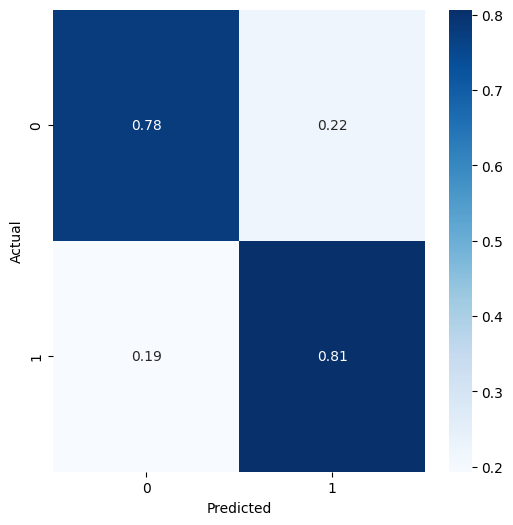

In [ ]:

##### confusion matrix-- visualization
import seaborn as sn
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
# 計算指標
print(f"Accuracy Score: {accuracy_score(target, prediction)*100:.2f}%")
print(f"Precision Score: {precision_score(target, prediction,average='weighted')*100:.2f}%")
print(f"Recall Score: {recall_score(target, prediction,average='weighted')*100:.2f}%")
print(f"F1 score: {f1_score(target, prediction,average='weighted')*100:.2f}%")

Accuracy Score: 77.60%
Precision Score: 99.36%
Recall Score: 77.60%
F1 score: 86.89%


In [ ]:
Accuracy Score: 77.60%
Precision Score: 99.36%
Recall Score: 77.60%
F1 score: 86.89%

# **3.決策樹**

In [ ]:
# -*- coding: utf-8 -*-
##  提供的資料格式   第一列是變數名稱
##  x1,x2,x3,x4…,xn,y

# parameters
x_no= 9     ## x的變數個數
y_no= 1     ## y的變數個數

window=1
ahead=0
seq_len = window + ahead



# read data file
# read data file
dataset = pd.read_csv("/content/gdrive/MyDrive/paper/df_tag.csv")
dataset.columns = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','y']
dataset.head()

data_length= len(dataset)

df_stock = dataset.copy()
df_stock = df_stock.dropna()  ## 去掉空的資料列!!

df_stock_X = df_stock.iloc[:,:-1]
df_stock_Y = df_stock.iloc[:,-1]

# normalize the dataset
from sklearn import preprocessing as skpp
from pandas import DataFrame

scaler = skpp.MinMaxScaler(feature_range=(0, 1))
df_stock_Xnorm = DataFrame(scaler.fit_transform(df_stock_X))

## 轉為 DataFrame
df_stock_Y = DataFrame(df_stock_Y)

##  將X and Y合併!
df_stock_Xnorm['tmp'] = np.arange(0,len(df_stock_Xnorm))
df_stock_Y['tmp'] = np.arange(0,len(df_stock_Y))

df_stock_new= pd.merge(df_stock_Xnorm, df_stock_Y, on=['tmp'])
df_stock_new = df_stock_new.drop('tmp', axis=1)

df_stock_norm= df_stock_new


############################
# data windows + Splitting the dataset into Train, Valid & test data
valid_set_size_percentage = 1
test_set_size_percentage = 30

def load_data(stock, seq_len):
    data_raw = stock
    data = []
    for index in range(len(data_raw) - seq_len+1):
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:window,: -y_no]
    y_train = data[:train_set_size,-1, -y_no:]
    x_valid = data[train_set_size:train_set_size+valid_set_size, :window,: -y_no]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1, -y_no:]
    x_test = data[train_set_size+valid_set_size:, :window,: -y_no]
    y_test = data[train_set_size+valid_set_size:,-1, -y_no:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


x_train, y_train, x_valid, y_valid, x_test, y_test= [],[],[],[],[],[]

i=0
df_stock_norm_temp = df_stock_norm.iloc[np.arange(data_length*i, data_length*i + data_length),:]
x_traint, y_traint, x_validt, y_validt, x_testt, y_testt = load_data(df_stock_norm_temp, seq_len)
x_train.append(x_traint)
y_train.append(y_traint)
x_valid.append(x_validt)
y_valid.append(y_validt)
x_test.append(x_testt)
y_test.append(y_testt)


##  4D to  3D
x_train=np.reshape(np.array(x_train), (-1, window, x_no))
y_train=np.reshape(np.array(y_train), (-1, y_no))

x_valid=np.reshape(np.array(x_valid), (-1, window, x_no))
y_valid=np.reshape(np.array(y_valid), (-1, y_no))

x_test=np.reshape(np.array(x_test), (-1, window, x_no))
y_test=np.reshape(np.array(y_test), (-1, y_no))


#########################################
##  看y 的 level 分布情形!
X=x_train
y=y_train

from sklearn.preprocessing import LabelEncoder
from collections import Counter

y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

##########################
## SMOTE

from imblearn.over_sampling import SMOTE

X=np.reshape(np.array(X), (len(x_train), -1))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

###########################
##  reshape x 資料
X=np.reshape(np.array(X), (-1, window ,x_no))

y_level=len(np.unique(y))   ## y 有多少levels

##  one-hot encoding
from keras.utils import np_utils
y_oneshot = np_utils.to_categorical(y)

y_valid= np_utils.to_categorical(y_valid)
y_test= np_utils.to_categorical(y_test)

############################################

x_train=X
y_train= y_oneshot

############################################

"""Building the LSTM Model"""

# parameters & Placeholders
n_steps = window
n_inputs = x_no
n_neurons = 256
n_outputs = y_level
n_layers = 2
learning_rate = 0.0005
batch_size = 150
n_epochs = 20
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
tf.disable_eager_execution()

##用 tf.placeholder 創造出未來存放 x 與 y 值的地方
X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)  ## 隨機排列

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [ ]:
df_gru = dataset.copy()
df_gru.head()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense


# 分割特徵和目標變數
X = df_gru.drop('y', axis=1)
y = df_gru['y']

# 使用SMOTE進行過抽樣
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 建立GRU模型
model = Sequential()
model.add(GRU(32, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

# 編譯模型
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 將特徵轉換為三維張量
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# 訓練模型
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# 預測測試集
#y_pred = model.predict_classes(X_test)
y_pred=(model.predict(X_test) > 0.5).astype("int32")
# 計算準確率
accuracy = accuracy_score(y_test, y_pred)
print("準確率:", accuracy)

# 製作混淆矩陣
cm = confusion_matrix(y_test, y_pred)

# 製作百分比的混淆矩陣圖
plt.figure(figsize=(8, 6))
sns.heatmap(cm/sum(sum(cm)), annot=True, fmt=".2%", cmap="Blues")
plt.title('GRU confusion_matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
# 製作混淆矩陣
cm = confusion_matrix(y_test, y_pred)

# 製作百分比的混淆矩陣圖
plt.figure(figsize=(8, 6))
sns.heatmap(cm/sum(sum(cm)), annot=True, fmt=".2%", cmap="Blues")
plt.title('Decision tree confusion_matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
clf = DecisionTreeClassifier(
    criterion='gini',            # 分割标准，CART使用基尼系数
    splitter='best',             # 分割策略，可选'best'或'random'
    max_depth=None,              # 树的最大深度
    min_samples_split=2,         # 分割内部节点所需的最小样本数
    min_samples_leaf=1,          # 叶节点上所需的最小样本数
    random_state=42              # 随机种子
)
clf.fit(X, y)
y_pred = clf.predict(X_test)
print(y_pred)
accuracy = clf.score(X_test, y_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"Precision Score: {precision_score(y_test, y_pred,average='micro')*100:.2f}%")
print(f"Recall Score: {recall_score(y_test, y_pred,average='micro')*100:.2f}%")
print(f"F1 score: {f1_score(y_test, y_pred,average='micro')*100:.2f}%")

# **4.決策樹(CART)**

In [ ]:
df_tr = df_ml.copy()
df_tr.head()

In [ ]:
# 將特徵和目標變數分開
X = df_tr.drop('y', axis=1)
y = df_tr['y']

# 切分訓練集和測試集（70%訓練集，30%測試集）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
#########################################
##  看y 的 level 分布情形!
X=X_train
y=y_train

from sklearn.preprocessing import LabelEncoder
from collections import Counter

y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
##########################
## SMOTE

from imblearn.over_sampling import SMOTE

X=np.reshape(np.array(X), (len(X_train), -1))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

# **5.羅吉斯迴歸**

In [ ]:

from sklearn.linear_model import LogisticRegression

# 載入資料
df_log = dataset.copy()
df_log.head()

# 分割特徵和目標變數
X = df_log.drop('y', axis=1)
y = df_log['y']

# 使用SMOTE進行過抽樣
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 建立邏輯回歸模型
model = LogisticRegression()

# 訓練模型
model.fit(X_train, y_train)

# 預測測試集
y_pred = model.predict(X_test)

# 計算準確率
accuracy = accuracy_score(y_test, y_pred)
print("準確率:", accuracy)

# 製作混淆矩陣
cm = confusion_matrix(y_test, y_pred)

# 製作百分比的混淆矩陣圖
plt.figure(figsize=(8, 6))
sns.heatmap(cm/sum(sum(cm)), annot=True, fmt=".2%", cmap="Blues")
plt.title('Logistic Regression confusion_matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# **總結**

In [ ]:

index = ['LSTM', 'RNN', '決策樹', 'GRU', '羅吉斯迴歸']
columns = ['整體準確率', '潛在詐欺判斷準確率']

data = [
    [0.84, 0.56],
    [0.85, 0.61],
    [0.98, 0.49],
    [0.94, 0.48],
    [0.81, 0.40]
]

df = pd.DataFrame(data, index=index, columns=columns)
display(df)